# New York City Hospital Simulation Modeling for COVID-19

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Acquiring-the-Data" data-toc-modified-id="Acquiring-the-Data-2">Acquiring the Data</a></span><ul class="toc-item"><li><span><a href="#Census-Demographic-Data" data-toc-modified-id="Census-Demographic-Data-2.1">Census Demographic Data</a></span></li><li><span><a href="#NYC-Deparment-of-Health-ZCTA-Data" data-toc-modified-id="NYC-Deparment-of-Health-ZCTA-Data-2.2">NYC Deparment of Health ZCTA Data</a></span></li><li><span><a href="#Merging-All-3-Data-Sets" data-toc-modified-id="Merging-All-3-Data-Sets-2.3">Merging All 3 Data Sets</a></span></li><li><span><a href="#NYC-Hospitals-Data" data-toc-modified-id="NYC-Hospitals-Data-2.4">NYC Hospitals Data</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3">Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#COVID-19-Choropleth-Map" data-toc-modified-id="COVID-19-Choropleth-Map-3.1">COVID-19 Choropleth Map</a></span></li></ul></li><li><span><a href="#Discrete-Event-Simulation" data-toc-modified-id="Discrete-Event-Simulation-4">Discrete Event Simulation</a></span><ul class="toc-item"><li><span><a href="#Hospital-Service-Area-Calculation" data-toc-modified-id="Hospital-Service-Area-Calculation-4.1">Hospital Service Area Calculation</a></span></li><li><span><a href="#Simulation-Set-Up" data-toc-modified-id="Simulation-Set-Up-4.2">Simulation Set Up</a></span></li><li><span><a href="#Run-Simulation" data-toc-modified-id="Run-Simulation-4.3">Run Simulation</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-5">Results</a></span><ul class="toc-item"><li><span><a href="#Comparison-Graphs" data-toc-modified-id="Comparison-Graphs-5.1">Comparison Graphs</a></span></li><li><span><a href="#Static-Map" data-toc-modified-id="Static-Map-5.2">Static Map</a></span></li></ul></li><li><span><a href="#Interactive-Map" data-toc-modified-id="Interactive-Map-6">Interactive Map</a></span><ul class="toc-item"><li><span><a href="#Map-in-Jupyter-Notebook" data-toc-modified-id="Map-in-Jupyter-Notebook-6.1">Map in Jupyter Notebook</a></span></li><li><span><a href="#More-Layers" data-toc-modified-id="More-Layers-6.2">More Layers</a></span></li><li><span><a href="#Export-Map" data-toc-modified-id="Export-Map-6.3">Export Map</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li></ul></div>

## Introduction

This project initially started as a means to explore the epidemiology of COVID-19 in New York City. At the end of March, when the city's Department of Health started releasing daily summaries of coronavirus related cases, hospitalizations and deaths, a Python script was written to save these numbers onto a spreadsheet. Once enough data was gathered, the purpose of this project changed from simply visualizing the impact of COVID-19, to diving deeper and examining the city's capability in handling the situation. This project will explore how well NYC hospitals can handle this crisis using a discrete event simulation method. 

In [1]:
import math
import json
import time
import requests
import pandas as pd
import geopandas as gpd
from datetime import datetime, date, timedelta

## Acquiring the Data

The NYC Department of Health releases their COVID-19 data at two geographic resolutions, by borough and by zip code. The borough data is too coarse to derive any useful spatial information for such a small study area. Therefore, we will be using their zip code data for this project. All of the datasets, besides the COVID-19 one, are accessed directly online through an API or a URL.

### Census Demographic Data

Start by downloading the demographic information into a __`Pandas`__ DataFrame. The following code uses the 2010 census data and aggregates the census blocks into zip codes. The 2010 census data is accessed using their API with an API key. To run the code below, acquire an API key [here](https://api.census.gov/data/key_signup.html). Set the `api_key` variable to the census API key they provide as a string.

In [2]:
# Set up variables to download census data
base_url = "https://api.census.gov/data/2010/dec/sf1?get={}&for=block:*&in=state:36 county:{}&key={}"
api_key = #ENTER API KEY HERE
variables = "GEO_ID,ZCTA5,P001001,P005003,P005004,P005006,P005010,P012002,P012026"

# The code below is the metadata for the census variables
# Age is left out since the census age groups need to be aggregated to fit the age groups from the NYC COVID-19 reports
var_url = "https://api.census.gov/data/2010/dec/sf1/variables.json"
var_dict = requests.get(var_url).json()['variables']
var_list = variables.split(',')
var_df = pd.DataFrame(var_dict)[var_list]
var_df = var_df.T[['label', 'concept', 'predicateType']]
var_df

,label,concept,predicateType
GEO_ID,Geography,HOUSING UNITS;TOTAL POPULATION IN OCCUPIED HOU...,string
ZCTA5,Zip Code Tabulation Area (Five-Digit),NaN,NaN
P001001,Total,TOTAL POPULATION,NaN
P005003,Total!!Not Hispanic or Latino!!White alone,HISPANIC OR LATINO ORIGIN BY RACE,int
P005004,Total!!Not Hispanic or Latino!!Black or Africa...,HISPANIC OR LATINO ORIGIN BY RACE,int
P005006,Total!!Not Hispanic or Latino!!Asian alone,HISPANIC OR LATINO ORIGIN BY RACE,int
P005010,Total!!Hispanic or Latino,HISPANIC OR LATINO ORIGIN BY RACE,int
P012002,Total!!Male,SEX BY AGE,int
P012026,Total!!Female,SEX BY AGE,int


From the 2010 census, download the demographic variables to ZCTA levels for rage, gender and age. The following chunk of code takes some time to run since it runs two nested loops to create the demographics table.

In [3]:
# Start timing the process
start_time = time.time()

# Dictionary of NYC boroughs and their county FIPS
nyc_counties = {'Bronx': '005', 'Brooklyn': '047', 'Manhattan': '061', 
                'Queens': '081', 'Staten Island': '085'}

# Dictionary of the number of census age variables that fall into each age group
age_groups = {'0to17': 4, 
              '18to44': 8, 
              '45to64': 5,
              '65to74': 3, 
              '75over': 3}

# Create a dataframe of demographic data by census tracts
df_list = []
# The census API URL does produces the data for each county
# The first loop will generate the census tract data for the 5 NYC counties
for county in nyc_counties:
    # Create a data frame with the population, race, and gender demographics
    county_fips = nyc_counties[county]
    url = base_url.format(variables, county_fips, api_key)
    response = requests.get(url)
    data = response.json()
    county_df = pd.DataFrame(data[1:], columns=data[0])
    county_df = county_df.set_index('GEO_ID')
    
    # Starting census age variable numbers for [Male, Female]
    num_list = [12003, 12027]
    
    # Combine the census age groups into those from the COVID-19 reports
    for group in age_groups:
        # Create the age variables string for the census API URL
        v_age_list = ['GEO_ID']
        n_var = age_groups[group]
        for num in num_list:
            for i in range(n_var):
                v_age = 'P0' +str(num)
                v_age_list.append(v_age)
                num += 1
        num_list = [num + n_var for num in num_list]
        age_vars = ','.join(v_age_list)
        
        # Create a data frame with the census age groups demographics
        age_url = base_url.format(age_vars, county_fips, api_key)
        age_data = requests.get(age_url).json()
        age_df = pd.DataFrame(age_data[1:], columns=age_data[0])
        # Group the census age groups into the NYC COVID-19 age groups
        age_df[group] = 0
        for col in v_age_list[1:]:
            age_df[group] += age_df[col].astype('int32')
        age_df = age_df[['GEO_ID', group]].set_index('GEO_ID')
        
        # Join age group data frame to the other demographics dataframe
        county_df = county_df.join(age_df)
    
    # Add county data frame to the list of other NYC county dataframes
    df_list.append(county_df)

# Combine all the county data frames in the list into one
df = pd.concat(df_list)

# Print the execution time of the above code
end_time = time.time()
print("Code Execution Time: ", end_time - start_time)

# Clean up data frame
df = df.drop(columns=['tract', 'block', 'state', 'county']).astype('int32')
col_names = {'ZCTA5': 'ZipCode', 'P001001': 'TotalPop', 'P005003': 'White', 
             'P005004': 'Black', 'P005006': 'Asian', 'P005010': 'Hispanic', 
             'P012002': 'Male', 'P012026': 'Female'}
nyc_df = df.rename(columns=col_names)

nyc_df.head()

Code Execution Time:  49.49564218521118


,ZipCode,TotalPop,White,Black,Asian,Hispanic,Male,Female,0to17,18to44,45to64,65to74,75over
GEO_ID,,,,,,,,,,,,,
1000000US360050001000001,99999,0,0,0,0,0,0,0,0,0,0,0,0
1000000US360050001000002,99999,0,0,0,0,0,0,0,0,0,0,0,0
1000000US360050001001023,11370,0,0,0,0,0,0,0,0,0,0,0,0
1000000US360050001001000,11370,8634,550,5020,21,2801,7724,910,367,6722,1504,36,5
1000000US360050001001008,11370,0,0,0,0,0,0,0,0,0,0,0,0


Using the modified ZCTA data from [NYC Health](https://github.com/nychealth/coronavirus-data/tree/master/Geography-resources), aggregate the census data to the `MODZCTA`'s and calculate the percentages of each demographic variable. Modified ZCTA combines census blocks with smaller populations to allow more stable estimates of population size for rate calculation.

In [4]:
# Use the reference table from the repository to convert ZCTA to MODZCTA
zcta_modzcta_url = "https://raw.githubusercontent.com/nychealth/coronavirus-data/master/Geography-resources/ZCTA-to-MODZCTA.csv"
zcta_modzcta_df = pd.read_csv(zcta_modzcta_url, index_col='ZCTA')
zcta_modzcta_df.index.name='ZipCode'
mod_df = nyc_df.join(zcta_modzcta_df, on='ZipCode').groupby('MODZCTA').sum().drop(columns='ZipCode')

# Convert the demographic variables from count to percentages of total population
mod_df.loc[:, mod_df.columns != 'TotalPop'] = round(
    mod_df.loc[:, mod_df.columns != 'TotalPop'].div(mod_df['TotalPop'], axis=0) * 100, 2)
mod_df.index.name='ZipCode'

mod_df.head()

,TotalPop,White,Black,Asian,Hispanic,Male,Female,0to17,18to44,45to64,65to74,75over
ZipCode,,,,,,,,,,,,
10001,21203,55.34,7.83,16.61,17.25,48.35,51.65,8.77,55.11,23.67,6.50,5.96
10002,81410,20.06,6.46,46.36,25.33,47.38,52.62,16.31,40.71,25.96,7.94,9.07
10003,56024,71.50,3.10,14.32,8.01,47.75,52.25,6.32,63.41,20.24,5.66,4.37
10004,3089,65.85,2.78,21.14,6.12,52.12,47.88,12.75,66.82,17.19,2.43,0.81
10005,7135,65.35,3.21,20.63,7.43,48.26,51.74,5.76,84.15,9.24,0.67,0.18


### NYC Deparment of Health ZCTA Data

From the same GitHub repository, access the modified zip code tabulation area (ZCTA) geometries

In [5]:
# Create a GeoDataFrame of ZCTAs
zcta_url = "https://raw.githubusercontent.com/nychealth/coronavirus-data/master/Geography-resources/MODZCTA_2010_WGS1984.geo.json"
zcta_geom = gpd.read_file(zcta_url).to_crs({'init': 'epsg:2263'})
# Keep only the zip codes and geometries
zcta_geom = zcta_geom.filter(['MODZCTA', 'geometry'])
zcta_geom = zcta_geom.rename(columns={'MODZCTA': 'ZipCode'}).dissolve(by='ZipCode')
# Add an area column
zcta_geom.insert(0, 'Area', zcta_geom.area)
zcta_geom.index = zcta_geom.index.astype(int)

zcta_geom.head()

,Area,geometry
ZipCode,,
10001,1.843464e+07,"POLYGON ((987646.108 210360.178, 988394.040 21..."
10002,2.455042e+07,"POLYGON ((984941.947 199431.837, 984997.953 19..."
10003,1.612608e+07,"POLYGON ((987399.935 202660.001, 987455.911 20..."
10004,4.096905e+06,"MULTIPOLYGON (((979869.883 194796.122, 980052...."
10005,2.080165e+06,"POLYGON ((982080.101 195430.122, 982534.015 19..."


### Merging All 3 Data Sets

Once the three ZCTA datasets&mdash;COVID-19 cases, demographics and geometries&mdash;are ready, combine them into one GeoDataFrame.

The COVID-19 data is provided by the NYC Department of Health's [COVID-19 Data Page](https://www1.nyc.gov/site/doh/covid/covid-19-data.page).

In [6]:
# Combine all the ZCTA datasets into one GeoDataFrame
# Read COVID-19 data
covid_zcta_df = pd.read_csv('covid_zctas.csv', index_col=0)
# Join COVID-19 to demographics data
covid_zcta_df = gpd.GeoDataFrame(mod_df.join(covid_zcta_df, how='outer'))
# Join geometries
zcta_gdf = gpd.GeoDataFrame(covid_zcta_df.join(zcta_geom, how='outer'))
# Keep only correct zip codes
zcta_gdf.index.name = "ZipCode"
zcta_gdf = zcta_gdf.query('ZipCode > 10000 & ZipCode < 20000')
zcta_gdf = zcta_gdf.reset_index().rename(columns={'index':'ZipCode'})

# Specify the GeoDataFrame's coordinate system
zcta_gdf.crs = 'EPSG:2263'

zcta_gdf.head()

,ZipCode,TotalPop,White,Black,Asian,Hispanic,Male,Female,0to17,18to44,...,2020-05-13,2020-05-14,2020-05-15,2020-05-19,2020-05-20,2020-05-21,2020-05-22,Tested,Area,geometry
0,10001,21203,55.34,7.83,16.61,17.25,48.35,51.65,8.77,55.11,...,323.0,327.0,334.0,336.0,338.0,341.0,344.0,1590.0,1.843464e+07,"POLYGON ((987646.108 210360.178, 988394.040 21..."
1,10002,81410,20.06,6.46,46.36,25.33,47.38,52.62,16.31,40.71,...,936.0,951.0,970.0,978.0,984.0,989.0,994.0,3234.0,2.455042e+07,"POLYGON ((984941.947 199431.837, 984997.953 19..."
2,10003,56024,71.50,3.10,14.32,8.01,47.75,52.25,6.32,63.41,...,422.0,424.0,426.0,429.0,433.0,434.0,436.0,2299.0,1.612608e+07,"POLYGON ((987399.935 202660.001, 987455.911 20..."
3,10004,3089,65.85,2.78,21.14,6.12,52.12,47.88,12.75,66.82,...,28.0,28.0,28.0,29.0,30.0,30.0,30.0,155.0,4.096905e+06,"MULTIPOLYGON (((979869.883 194796.122, 980052...."
4,10005,7135,65.35,3.21,20.63,7.43,48.26,51.74,5.76,84.15,...,55.0,56.0,57.0,58.0,59.0,59.0,59.0,382.0,2.080165e+06,"POLYGON ((982080.101 195430.122, 982534.015 19..."


### NYC Hospitals Data

Finally, download the NYC hospitals point data to a GeoDataFrame. The NYU dataset includes hospital capacity which will be used in the discrete event simulation.

In [7]:
# Get hospital point data
hospitals_url = "https://geo.nyu.edu/download/file/nyu-2451-34494-geojson.json"
hospitals_geom = gpd.read_file(hospitals_url).to_crs({'init': 'epsg:2263'})
# Drop hospitals that don't have beds
hospitals_geom = hospitals_geom.dropna(subset=['capacity'])

hospitals_geom.head()

,id,name,address,zip,factype,facname,capacity,capname,bcode,xcoord,ycoord,geometry
0,317000001H1178,BRONX-LEBANON HOSPITAL CENTER - CONCOURSE DIVI...,1650 Grand Concourse,10457,3102,Hospital,415.0,Beds,36005,1008872,246596,POINT (1008872.000 246596.000)
1,317000001H1164,BRONX-LEBANON HOSPITAL CENTER - FULTON DIVISION,1276 Fulton Ave,10456,3102,Hospital,164.0,Beds,36005,1011044,242204,POINT (1011044.000 242204.000)
2,317000011H1175,CALVARY HOSPITAL INC,1740-70 Eastchester Rd,10461,3102,Hospital,225.0,Beds,36005,1027505,248287,POINT (1027505.000 248287.000)
3,317000002H1165,JACOBI MEDICAL CENTER,1400 Pelham Pkwy,10461,3102,Hospital,457.0,Beds,36005,1027042,251065,POINT (1027042.000 251065.000)
4,317000008H1172,LINCOLN MEDICAL & MENTAL HEALTH CENTER,234 E 149 St,10451,3102,Hospital,362.0,Beds,36005,1005154,236853,POINT (1005154.000 236853.000)


## Exploratory Data Analysis

A good idea before performing any statistical analysis or modeling is to explore the you have. For spatial data, the best way is to map them out as vectors or rasters. We will be using the __`matplotlib`__ package to visualize the relationship between COVID-19 data and hospital locations.

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter

### COVID-19 Choropleth Map

Below is a choropleth map showing the current total number of confirmed positive cases in NYC by ZCTA, with a hospital point layer.

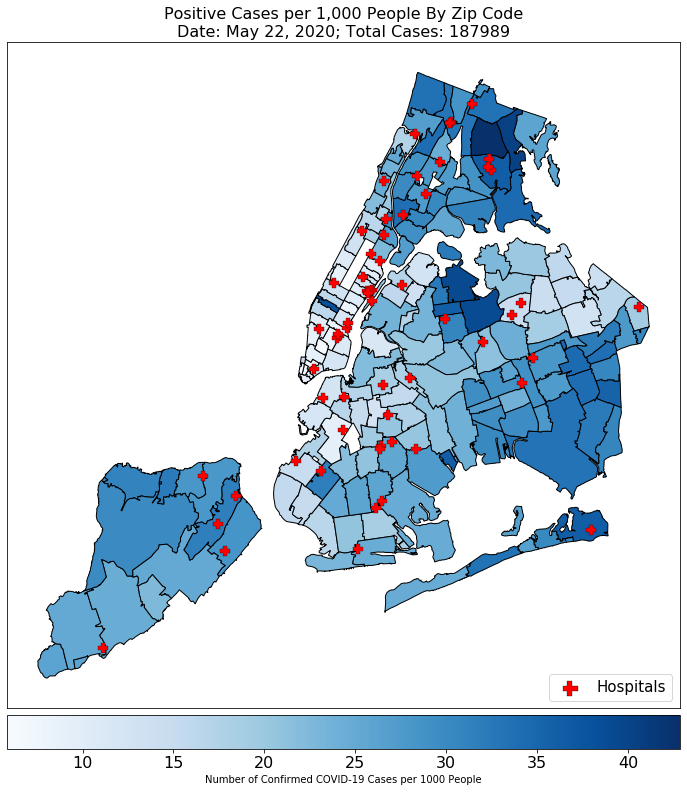

In [9]:
# Set the date to the most recently reported date
day = (datetime.today() - timedelta(days=2)).strftime('%Y-%m-%d')
# zcta_pos = zcta_gdf.copy()

# Calculate the mapped criteria as the total number of positive cases per 1000 persons in a ZCTA
column = zcta_gdf[day] / zcta_gdf['TotalPop'] * 1000

# Set up the map
fig, ax = plt.subplots(figsize=(13, 13))

# Add the title
date_str = datetime.strptime(day, '%Y-%m-%d').strftime('%b %d, %Y')
total = int(zcta_gdf[day].sum())
title = 'Positive Cases per 1,000 People By Zip Code\nDate: {}; Total Cases: {}'.format(date_str, total)
plt.title(title, size='16')

# Create the legend
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.1)
cax.tick_params(labelsize=16)
ax.tick_params(left=0, labelleft=0, bottom=0, labelbottom=0)
legend_kwds = {'label': 'Number of Confirmed COVID-19 Cases per 1000 People',
               'orientation': 'horizontal'}

# Plot the ZCTA data
zcta_gdf.plot(ax=ax, column=column, cmap='Blues', edgecolor='black', legend=True, cax=cax, 
              legend_kwds=legend_kwds)

# Add the hospitals layer
hospitals_geom.plot(ax=ax, marker='P', markersize=100, color='red',
                    edgecolor='black', linewidth=.3)
# Add the hospitals legend
ax.legend(labels=['Hospitals'], loc='lower right', prop={'size': 15}, 
          markerscale=1.5)

plt.show()

## Discrete Event Simulation

Discrete event simulation (DES) is used to model the operation of a system as a sequence of events and states in time. The events are recreated so that the system's timing and resource implications can be examined. DES operates under the assumption that these events occur instantaneously at discrete points in time. After each event, the entity is in a new state. It has been used for many years to improve workflows and services. 

For example, imagine a supermarket with 6 cash registers and a queue of customers. In this system (the supermarket checkout) the registers are the resources and the customers are the entities. The 3 basic events that occur are: 
1. a customer gets in line
2. a customer is rung up at the register
3. they leave the supermarket. 

Although each event is discrete, the duration from when one occurs until the next is not. This span of time is measured in a discrete event simulation to assess how well the system can allocate resources efficienctly.

In this project, we will be modelling how well New York City hospitals can manage the COVID-19 crisis. Here, the basic events are:
1. a patients arrival at a hospital
2. if a bed is available they are admitted or
3. if no beds are available they are turned away
4. a patient is discharged from the hospital

The image below shows a simple DES workflow.
![DES](http://bestirtech.com/blog/wp-content/uploads/2019/07/DES_2.png)

This project uses the discrete event simulation Python package, __`SimPy`__. __`SimPy`__ uses Python generator functions, called processes that create events and `yield`s them in order to wait for them to be activated. Here is a simple [SimPy Tutorial](https://simpy.readthedocs.io/en/latest/simpy_intro/index.html) that explains how the package works and introduces you to `environment`s and `process`es. To understand more about `generator`s and the `yield` statement, check out [this article](https://realpython.com/introduction-to-python-generators/).

In [10]:
import simpy
import random
import numpy as np
from sklearn.neighbors import BallTree

### Hospital Service Area Calculation

The first thing to be done before creating the simulation is to calculate the service area of each hospital in New York City. To do this, we are using the nearest neighbor analysis between the hospitals points from `hospitals_geom` and the ZCTA centroids in `zcta_gdf`. The nearest neighbor calculation will use the two functions below.

In [11]:
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return closest


def nearest_neighbor(left_gdf, right_gdf, left_id, right_id):
    """For each point in left_gdf, find the closest point in right_gdf"""
    
    # The function requires the GeoDataFrames to be in WGS 84
    # Reproject both GeoDataFrames, dropping any rows with no geometries
    left_gdf_wgs84 = left_gdf.dropna(subset=['geometry']).to_crs({'init': 'epsg:4326'}).reset_index()
    right_gdf_wgs84 = right_gdf.dropna(subset=['geometry']).to_crs({'init': 'epsg:4326'}).reset_index()
    
    # Use the centroid of the left GeoDataFrame to in the algorithm
    left_gdf_wgs84['centroid'] = left_gdf_wgs84.centroid
    left_geom_col='centroid'
    right_geom_col='geometry'
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf_wgs84.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf_wgs84[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # get the index in right_gdf_wgs84 that corresponds to the closest point
    closest = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf_wgs84
    closest_points = closest_points.reset_index(drop=True)
    
    # Join and return a data frame with the id's of the closest points
    df = left_gdf_wgs84.join(closest_points[right_id])[[left_id, right_id]]
    return left_gdf.join(df.set_index(left_id), on=left_id)

With the functions above, we will find the nearest hospital to each ZCTA, and then the service area of each hospital. This is done by grouping the data frame returned from the `nearest_neighbor` function by the unique hospital ID and totalling the values in each group. 

The average daily new COVID-19 cases `avgnewcases` are calculated for each hospital by averaging the difference between consecutive columns for the 30 days from April 3rd to May 3rd. Everything is gathered together into a `hospitals_gdf` GeoDataFrame.

In [12]:
# Aggregate all the zcta_gdf data to the ZCTA's nearest hospital
nearest_hosp = nearest_neighbor(
    zcta_gdf, hospitals_geom, 
    'ZipCode', 'id').groupby('id').sum()

# Add a column for the number of new daily COVID-19 cases for that hospitals service area
# Calculate the average number of new cases each day from 4/3 to 5/3
nearest_hosp['avgnewcases'] = nearest_hosp.iloc[:, 14:44].diff(axis=1).mean(axis=1).astype(int)
# Add a column for the number of cases when DOH started reporting by zip code, 4/1
day_start = '2020-04-01'
hospitals_gdf = hospitals_geom.join(
    nearest_hosp[[day_start, 'avgnewcases']].rename(
        columns={day_start: 'cases'}), 
    on='id')

hospitals_gdf.head()

,id,name,address,zip,factype,facname,capacity,capname,bcode,xcoord,ycoord,geometry,cases,avgnewcases
0,317000001H1178,BRONX-LEBANON HOSPITAL CENTER - CONCOURSE DIVI...,1650 Grand Concourse,10457,3102,Hospital,415.0,Beds,36005,1008872,246596,POINT (1008872.000 246596.000),741.0,107.0
1,317000001H1164,BRONX-LEBANON HOSPITAL CENTER - FULTON DIVISION,1276 Fulton Ave,10456,3102,Hospital,164.0,Beds,36005,1011044,242204,POINT (1011044.000 242204.000),586.0,86.0
2,317000011H1175,CALVARY HOSPITAL INC,1740-70 Eastchester Rd,10461,3102,Hospital,225.0,Beds,36005,1027505,248287,POINT (1027505.000 248287.000),741.0,94.0
3,317000002H1165,JACOBI MEDICAL CENTER,1400 Pelham Pkwy,10461,3102,Hospital,457.0,Beds,36005,1027042,251065,POINT (1027042.000 251065.000),832.0,120.0
4,317000008H1172,LINCOLN MEDICAL & MENTAL HEALTH CENTER,234 E 149 St,10451,3102,Hospital,362.0,Beds,36005,1005154,236853,POINT (1005154.000 236853.000),1025.0,134.0


### Simulation Set Up

With the `hospitals_gdf` set up, we can start creating the discrete event simulation. The code below creates the system and processes needed for the simulation. A `Hospital` class is created for the system being simulated, containing a limited capacity of resources, `beds`. The `patient` process function simulates a patient arriving at, being admitted, and being released from a hospital.

In [13]:
class Hospital():
    '''
    A hospital has a limited number of beds for patients. 
    
    A patient will request for a bed. If one is available they will stay for a length of time and be released.
    
    '''
    def __init__(self, env, num_beds):
        self.env = env
        self.bed = simpy.Resource(env, num_beds)
    
    def fill_bed(self, patient, length_of_stay):
        '''The patient admission process. It takes a "patient" process and admits them to the hospital.'''
        yield self.env.timeout(length_of_stay)


def patient(env, name, status, hosp, df):
    '''
    The "patient" process arrives at the hospital and requests for admission.
    
    Parameters:
        name: patient's name
        status: COVID-19 status (Positive/Negative)
        hosp: the hospital (as a class object)
        df: a dataframe to track the number of patients, released and refused from the hospital
    '''
    
    with hosp.bed.request() as admit:
        # Be admitted to the hopsital or refused if no beds are available
        results = yield admit | env.timeout(0)
        
        # Check if the patient is admitted or refused
        if admit in results:
            # Add 1 to the admitted column in the data frame
            counter(env, df, 'admitted')
            
            # If the patient was not admitted due to COVID-19, stay between 0 to 14 days
            if status == 'negative':
                num = int(round(np.random.normal(4, 3, 1)[0]))
                if num <= 0:
                    num = 0
                length_of_stay = num
            
            # If the patient was admitted because of COVID-19, stay between ~7 to ~34 days
            else:
                length_of_stay = int(round(np.random.normal(19, 3, 1)[0]))
            yield env.process(hosp.fill_bed(name, length_of_stay))
            
            # Add 1 to the released column when the patient is released
            counter(env, df, 'released')
        
        # If the patient was refused, add 1 to the refused column in the data frame
        else:
            counter(env, df, 'refused')


def setup(env, start_patients, num_beds, new_patients, df):
    '''Create a hospital, the number of initial patients and keep creating new patients'''
    # Create the hospital
    hospital = Hospital(env, num_beds)
    
    # Create the inital number of patients already in the hospital
    for i in range(start_patients):
        env.process(patient(env, 'Patient{}'.format(i), 'negative', hospital, df))
    
    # Create more patients while the simulation is running
    while True:
        yield env.timeout(1)
        
        # Randomly generate the number of new patients each day
        num = int(round(np.random.normal(new_patients, 5, 1)[0]))
        if num <= 0:
            num = 0
        
        for j in range(num):
            i += 1
            env.process(patient(env, 'Patient{}'.format(i), 'positive', hospital, df))

            
def counter(env, df, col_name):
    '''Helper function to track the number of patients admitted, released, and refused at a hospital'''
    loc = df.columns.get_loc(col_name)
    l = [0] * len(df.columns)
    l[loc] = 1
    
    if env.now not in df.index:
        df.loc[env.now] = l
    else:
        df.loc[env.now][col_name] += 1

### Run Simulation

Now that the system and process are defined, we will set up and start the simulation. The code below iterates through each hospital in the `hospitals_gdf` GeoDataFrame: 
- creates a __`SimPy`__ environment for that hospital
- sets up the variables for the simulation
- runs the simulation
- creates a __`Pandas`__ DataFrame that tracks the number of patients admitted, released, and refused in that hospital. 

The simulation is run for 60 days. 

The number of starting patients uses the occupancy rate percentages from the [American Hospital Directory](https://www.ahd.com/news/HFM_DataTrends_2018_July.pdf). The percentage of patients that are admitted to a hospital due to COVID-19 is from the [CDC](https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html).

We will also time how long this process takes.

In [14]:
# Separate the hospitals that do not have a service area as overflow hospitals
hospitals_overflow = hospitals_gdf[hospitals_gdf['cases'].isna()]
hospitals_sim = hospitals_gdf.dropna(subset=['cases'])

# Start timing the process
start_time = time.time()

# Run the simulation for each hospital in the GeoDataFrame and add them to a dictionary
sim_dict = dict()
for index, row in hospitals_sim.iterrows():
    # Set the simulation environment
    env = simpy.Environment()
    
    # Definte the environment parameters
    start_patients = int(row['capacity'] * 0.7419)
    num_beds = row['capacity']
    new_patients = int(row['avgnewcases'] * 0.19)
    
    # Create an empty admitted, released, refused (ARR) dataframe
    hospital_df = pd.DataFrame(columns=['admitted', 'released', 'refused'])
    
    # Set up the simulation with parameters from the above variables
    env.process(setup(env, start_patients, num_beds, new_patients, hospital_df))
    
    # Run the simulation for 60 days
    # 61 is used since the simulation starts at day 0 and ends at sim_days - 1
    sim_days = 61
    env.run(until=sim_days)
    
    # Add the hospital's ARR dataframe to the dictionary
    hosp_name = row['name']
    sim_dict[hosp_name] = hospital_df

# Print the execution time of the above code
end_time = time.time()
print("Code Execution Time: ", end_time - start_time)

Code Execution Time:  18.178247690200806


## Results

### Comparison Graphs

The simulation created around 55 data frames tracking the number of patients admitted, released and refused at each hospital. Let's explore two of these tables. We will compare the results from Elmhurst Hospital in Elmhurst, Queens and NewYork-Presbyterian Brooklyn Methodist Hospital in Park Slope, Brooklyn.

Both hospitals have the about the same number of beds, however, Elmhurst Hospital covers a larger service area with more new cases each day. Therefore, Elmhurst Hospital simply does not have enough resources to accommodate the higher demand.

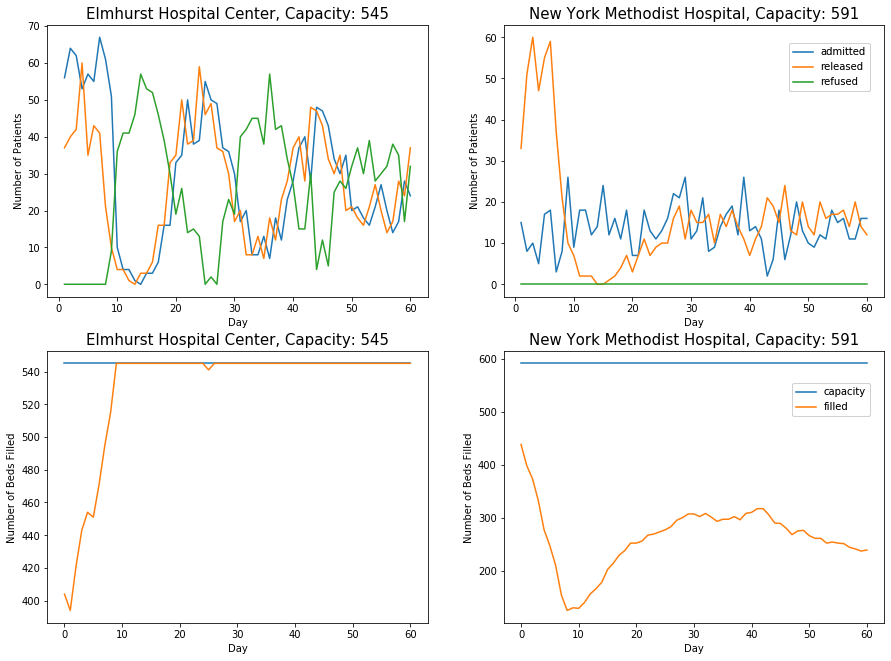

In [15]:
# Create a list of hospitals
hospitals = ['ELMHURST HOSPITAL CENTER', 'NEW YORK METHODIST HOSPITAL']

# Set up two side-by-side plots
fig = plt.figure(figsize=(15, 11))
for i, hospital in enumerate(hospitals, start=1):
    # Plot the number of patients admitted, released and refused
    ax = fig.add_subplot(2, 2, i)
    df = sim_dict[hospital].copy()
    df[['admitted', 'released', 'refused']].iloc[1:].plot(ax=ax, legend=False)

    # Add titles
    hosp_capacity = hospitals_geom.loc[hospitals_geom['name'] == hospital]['capacity'].item()
    title = '{}, Capacity: {}'.format(hospital.title(), int(hosp_capacity))
    plt.title(title, size=15)
    plt.xlabel('Day')
    plt.ylabel('Number of Patients')
    
    # Add a legend for the first two plots
    h, l = ax.get_legend_handles_labels()
    fig.legend(h, l, loc='center right', bbox_to_anchor=(0.81, 0.75))
    
    # Plot the number of beds filled and the capacity
    ax = fig.add_subplot(2, 2, i+2)
    df['filled'] = (df['admitted'] - df['released'].shift(1, fill_value=0)).cumsum()
    df['capacity'] = int(hosp_capacity)
    df[['capacity', 'filled']].plot(ax=ax, legend=False)
    
    # Add titles
    plt.title(title, size=15)
    plt.xlabel('Day')
    plt.ylabel('Number of Beds Filled')
    
    # Add a legend for the bottom two plots
    h, l = ax.get_legend_handles_labels()
    fig.legend(h, l, loc='center right', bbox_to_anchor=(0.81, 0.33))

plt.show()

### Static Map

After exploring a sample of the simulation results, let's map everything out to see how many patients were admitted, released, and refused from all the hospitals. To start, we must add the sum of these values for each hospital in the `sim_dict` to the `hospital_sim` GeoDataFrame as three new columns.

In [16]:
# For each hospital in the dictionary, append the column total to a list
hosp_list = list()
for hospital in sim_dict:
    # Get the sum of each column as a 3 row series
    df = sim_dict[hospital].copy()
    hosp_summary = df.sum(axis=0)
    # Get the hospital ID as the series name
    hosp_id = hospitals_sim.loc[hospitals_sim['name'] == hospital]['id'].item()
    hosp_summary.name = hosp_id
    # Append to list of DataFrames
    hosp_list.append(hosp_summary)
# Combine list of DataFrames into 1
hosp_summary_df = pd.concat(hosp_list, axis=1).transpose()

# Join the new columns to the hospital GeoDataFrame
hosp_sim_gdf = hospitals_sim.join(hosp_summary_df, on='id')

hosp_sim_gdf.head()

,id,name,address,zip,factype,facname,capacity,capname,bcode,xcoord,ycoord,geometry,cases,avgnewcases,admitted,released,refused
0,317000001H1178,BRONX-LEBANON HOSPITAL CENTER - CONCOURSE DIVI...,1650 Grand Concourse,10457,3102,Hospital,415.0,Beds,36005,1008872,246596,POINT (1008872.000 246596.000),741.0,107.0,1504.0,1126.0,13.0
1,317000001H1164,BRONX-LEBANON HOSPITAL CENTER - FULTON DIVISION,1276 Fulton Ave,10456,3102,Hospital,164.0,Beds,36005,1011044,242204,POINT (1011044.000 242204.000),586.0,86.0,634.0,475.0,461.0
2,317000011H1175,CALVARY HOSPITAL INC,1740-70 Eastchester Rd,10461,3102,Hospital,225.0,Beds,36005,1027505,248287,POINT (1027505.000 248287.000),741.0,94.0,870.0,654.0,398.0
3,317000002H1165,JACOBI MEDICAL CENTER,1400 Pelham Pkwy,10461,3102,Hospital,457.0,Beds,36005,1027042,251065,POINT (1027042.000 251065.000),832.0,120.0,1565.0,1144.0,0.0
4,317000008H1172,LINCOLN MEDICAL & MENTAL HEALTH CENTER,234 E 149 St,10451,3102,Hospital,362.0,Beds,36005,1005154,236853,POINT (1005154.000 236853.000),1025.0,134.0,1384.0,1039.0,356.0


With the simulation results all in one GeoDataFrame `hosp_sim_gdf`, let's plot the data onto a static map. In the map below, the hospitals are plotted as circles with the number of patients refused at a hospital to representing the size of each circle. Hospitals that did not refuse any patients are smaller pink circles.

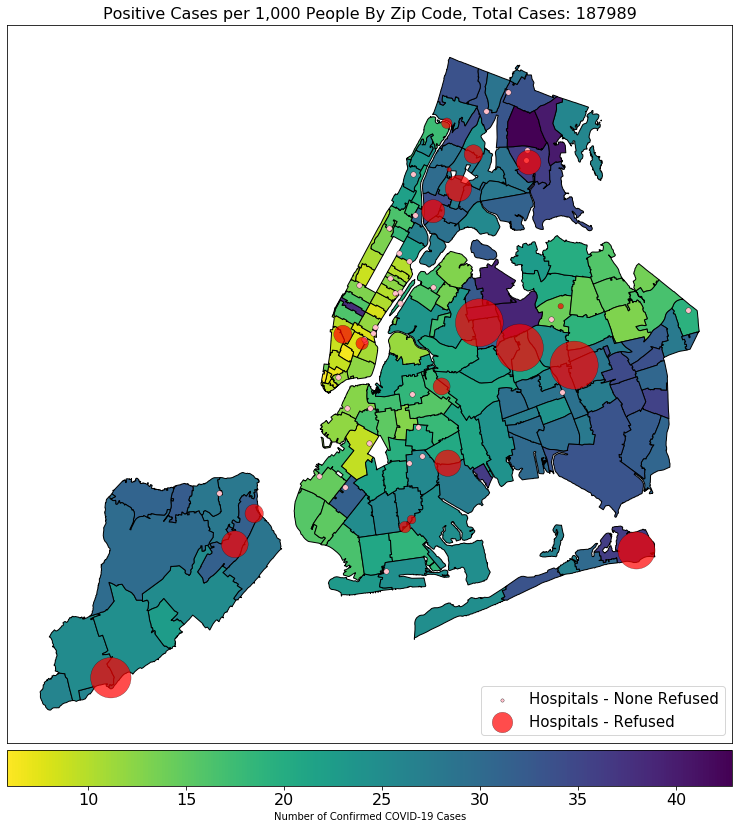

In [17]:
# Set up figure
fig, ax = plt.subplots(figsize=(14, 14))

# Add title
title = 'Positive Cases per 1,000 People By Zip Code, Total Cases: ' + str(total)
plt.title(title, size='16')

# Create the colorbar legend
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.1)
cax.tick_params(labelsize=16)
ax.tick_params(left=0, labelleft=0, bottom=0, labelbottom=0)
legend_kwds = {'label': 'Number of Confirmed COVID-19 Cases',
               'orientation': 'horizontal'}

# Plot the ZCTA polygons by COVID-19 cases
column = zcta_gdf[day] / zcta_gdf['TotalPop'] * 1000
zcta_gdf.plot(ax=ax, column=column, cmap='viridis_r', edgecolor='black', 
              legend=True, cax=cax, legend_kwds=legend_kwds)

# Add the two hospital layers
hosp_sim_gdf[hosp_sim_gdf['refused'] == 0].plot(
    ax=ax, marker='o', markersize=30,
    color='pink', edgecolor='black', linewidth=.3)

hosp_sim_gdf.plot(
    ax=ax, marker='o', markersize=hosp_sim_gdf['refused']*1.5, 
    color='red', alpha=0.7, edgecolor='black', linewidth=.3)

# Add the hospitals legend
ax.legend(labels=['Hospitals - None Refused', 'Hospitals - Refused'], 
          loc='lower right', prop={'size': 15}, markerscale=0.6)

plt.show()

## Interactive Map

In this section of the report, we will be using the __`folium`__ package to create an interactive map based on the __`leaflet.js`__ library. __`folium`__ allows for us to view mutliple layers to one map, with the ability to turn each of them on or off. We will also be using the __`vincent`__ library to add graphs to the map. Guides for both packages can be found [here for __`folium`__](https://python-visualization.github.io/folium/) and [here for __`vincent`__](https://vincent.readthedocs.io/en/latest/).

In [18]:
import folium
import vincent

### Map in Jupyter Notebook

A simple two layer map is created in the code below because I had a problem with Jupyter Notebooks not displaying the output when multiple polygon layers are added to one map. However, this issue doesn't affect the HTML file output when saving the map, so in the following chunks of code, more layers are created and added to the map and written as an HTML file, `discrete-event-simulation-map.html`.

In [19]:
# The GeoDataFrames need to be in WGS84 to be mapped correctly to a basemap
zcta_wgs84 = zcta_gdf.dropna(subset=['geometry']).to_crs('EPSG:4326').reset_index(drop=True)
hosp_wgs84 = hosp_sim_gdf.to_crs('EPSG:4326')

# Convert the GeoDataFrames into GeoJSON format dictionary
zcta_data = gpd.GeoDataFrame(zcta_wgs84).__geo_interface__
hosp_data = gpd.GeoDataFrame(hosp_wgs84).__geo_interface__

# Create the COVID-19 choropleth layer
date = '2020-05-21'
covid_layer = folium.Choropleth(
    # Geometry data as a GeoJSON dictionary
    geo_data=zcta_data,
    name='COVID-19 Cases',
    # Values to map
    data=zcta_wgs84,
    # DataFrame columns formatted as ['Key', 'Value']
    columns=['ZipCode', date],
    # Where in the GeoJSON the above Key is found
    key_on='feature.properties.ZipCode',
    # ColorBrewer colormap
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='COVID-19 Cases',
    # Highlights the polygon when hovered over
    highlight=True)

# Create a tool tip to display information when the cursor is place over an object
covid_layer.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['ZipCode', date],
        aliases=['Zip Code:', 'COVID-19 Cases:']))

# Create a FeatureGroup for each hospital using a for-loop
refused_group = folium.FeatureGroup(name='Hospitals - Refused')
for i in range(len(hosp_data['features'])):
    # Set the location of each marker from the feature's coordinates
    location = [hosp_data['features'][i]['geometry']['coordinates'][1], 
                hosp_data['features'][i]['geometry']['coordinates'][0]]
    
    # Get the variable names from the dictionary
    hosp_name = hosp_data['features'][i]['properties']['name']
    hosp_capacity = hosp_data['features'][i]['properties']['capacity']
    refused = hosp_data['features'][i]['properties']['refused']
    # Vary the size of each circle by the patients refused
    if refused == 0:
        radius = 3
    else:
        radius = math.ceil((refused + 200) / 50)
    
    # Create a Vega chart for the number of beds filled during the simulation
    df = sim_dict[hosp_name]
    df['filled'] = (df['admitted'] - df['released'].shift(1, fill_value=0)).cumsum()
    df['capacity'] = int(hosp_capacity)
    chart = vincent.Line(df[['capacity', 'filled']], width=300, height=200)
    chart.axis_titles(x='Simulation Days', y='Number of Beds')
    chart.legend(title='Legend')
    
    # Make the Vega chart a popup when you click on a hospital marker
    hosp_popup = folium.Popup()
    folium.Vega(chart, width=chart.width+120, height=chart.height+50).add_to(hosp_popup)
    
    # Create a tool tip
    hosp_tooltip = """
    <b>Hospital</b><br>
    {}<br>
    <b>Capacity</b><br>
    {}<br><br>
    <b><i>Simulation Results</i></b><br>
    <b>Total Patients Refused</b><br>
    {}<br><br>
    <b>Click to view graph</b>
    """.format(hosp_name.title(), int(hosp_capacity), int(refused))
    
    # Using the above variables, create a circle marker for each hospital
    folium.CircleMarker(
        location=location,
        radius=radius,
        popup=hosp_popup,
        tooltip=hosp_tooltip,
        fill=True,
        fill_color='red',
        opacity=0,
        fill_opacity=0.5).add_to(refused_group)

# Make a folium map centering on NYC
m = folium.Map(
    location=[40.71, -73.95],
    tiles=None,
    zoom_start=11)

# Add the ZCTA polygon layer
covid_layer.add_to(m)
# Add the hospitals marker feature group
refused_group.add_to(m)
# Add a basemap
folium.TileLayer('CartoDB Positron', name='CartoDB').add_to(m)
# Add layer controls to turn on/off a layer
folium.LayerControl('topleft').add_to(m)

display(m)

### More Layers

As stated before, if multiple choropleth layers are added to the __`folium`__ map, Jupyter Notebook has a problem displaying it. Therefore, the bottom chunk of codes will create new layers of demographic data, and hospital data and add them to a map which would be saved as an output HTML file.

Now we will create some choropleth polygon layers.

In [20]:
# Create a white percentage ZCTA layer
whitepct_layer = folium.Choropleth(
    geo_data=zcta_data,
    name='White Pop',
    data=zcta_wgs84,
    columns=['ZipCode', 'White'],
    key_on='feature.properties.ZipCode',
    fill_color='Greens',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='White Population (%)',
    highlight=True,
    # Do not display layer when opened, turn on using layer control widget
    show=False)
# Add tool tip
whitepct_layer.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['ZipCode', 'White'],
        aliases=['Zip Code:', 'White Population %:']))

# Create a bin for the percentage of people over 75 ZCTA layer
age_bins = list(zcta_wgs84['75over'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
# Create a layer using the bin
over75pct_layer = folium.Choropleth(
    geo_data=zcta_data,
    name='Over 75 Pop',
    data=zcta_wgs84,
    columns=['ZipCode', '75over'],
    key_on='feature.properties.ZipCode',
    bins = age_bins,
    fill_color='Greys',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population Over 75 (%)',
    highlight=True,
    show=False)
# Add tool tip
over75pct_layer.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['ZipCode', '75over'],
        aliases=['Zip Code:', 'Population Over 75 (%):']))

# Create a male percentage layer with bin
gender_bins = list(zcta_wgs84['Male'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
malepct_layer = folium.Choropleth(
    geo_data=zcta_data,
    name='Male Pop',
    data=zcta_wgs84,
    columns=['ZipCode', 'Male'],
    key_on='feature.properties.ZipCode',
    bins=gender_bins,
    fill_color='YlOrBr',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Male Population (%)',
    highlight=True,
    show=False)
# Add tool tip
malepct_layer.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['ZipCode', 'Male'],
        aliases=['Zip Code:', 'Male Population (%):']))

Now that we are done making the polygon layers, let's add more point layers using the hospital data.

In [21]:
# Create a feature group for the number of patients released at each hospital
released_group = folium.FeatureGroup(name='Hospitals - Released', show=False)
for i in range(len(hosp_data['features'])):
    location = [hosp_data['features'][i]['geometry']['coordinates'][1], 
                hosp_data['features'][i]['geometry']['coordinates'][0]]
    
    hosp_name = hosp_data['features'][i]['properties']['name']
    hosp_capacity = hosp_data['features'][i]['properties']['capacity']
    admitted = hosp_data['features'][i]['properties']['admitted']
    released = hosp_data['features'][i]['properties']['released']
    if released == 0:
        radius = 3
    else:
        radius = math.ceil((released + 200) / 50)
    
    # Create a Vega chart of the number of patients admitted, released, and refused
    df = sim_dict[hosp_name]
    chart = vincent.Line(df[['admitted', 'released', 'refused']].iloc[1:], width=300, height=200)
    chart.axis_titles(x='Simulation Days', y='Number of Patients')
    chart.legend(title='Legend')
    
    # Add the chart as a popup
    hosp_popup = folium.Popup()
    folium.Vega(chart, width=chart.width+120, height=chart.height+50).add_to(hosp_popup)
    
    # Create a tool tip
    hosp_tooltip = """
    <b>Hospital</b><br>
    {}<br>
    <b>Capacity</b><br>
    {}<br><br>
    <b><i>Simulation Results</i></b><br>
    <b>Total Patients Admitted</b><br>
    {}<br>
    <b>Total Patients Released</b><br>
    {}<br><br>
    <b>Click to view graph</b>
    """.format(hosp_name.title(), int(hosp_capacity), 
               int(admitted), int(released))
    
    # Create a circle marker for each hospital
    folium.CircleMarker(
        location=location,
        radius=radius,
        popup=hosp_popup,
        tooltip=hosp_tooltip,
        fill=True,
        fill_color='green',
        opacity=0,
        fill_opacity=0.5).add_to(released_group)

Remember earlier where we removed the hospitals that didn't have a service area and only ran the simulation on hospitals that do? Well now, let's add those "overflow" hospitals to the map.

In [22]:
# Reproject and convert the data into a GeoJSON dictionary
overflow_wgs84 = hospitals_overflow.to_crs('EPSG:4326')
overflow_data = gpd.GeoDataFrame(overflow_wgs84).__geo_interface__

# Create a feature group for the overflow hospitals
overflow_group = folium.FeatureGroup(name='Hospitals - Overflow', show=False)
for i in range(len(overflow_data['features'])):
    location = [overflow_data['features'][i]['geometry']['coordinates'][1], 
                overflow_data['features'][i]['geometry']['coordinates'][0]]
    
    hosp_name = overflow_data['features'][i]['properties']['name']
    hosp_capacity = overflow_data['features'][i]['properties']['capacity']
    
    hosp_tooltip = """
    <b>Hospital</b><br>
    {}<br>
    <b>Capacity</b><br>
    {}
    """.format(hosp_name.title(), int(hosp_capacity), int(refused))
    
    folium.CircleMarker(
        location=location,
        radius=5,
        tooltip=hosp_tooltip,
        fill=True,
        fill_color='orange',
        opacity=0,
        fill_opacity=0.8).add_to(overflow_group)

### Export Map

Now that all the layers have been created, add all the layers onto one map and export it into a HTML file. To view the output, click [here](discrete-event-simulation-map.html).

In [23]:
m = folium.Map(
    location=[40.71, -73.95],
    tiles=None,
    zoom_start=11)

covid_layer.add_to(m)
whitepct_layer.add_to(m)
over75pct_layer.add_to(m)
malepct_layer.add_to(m)
refused_group.add_to(m)
released_group.add_to(m)
overflow_group.add_to(m)
folium.TileLayer('CartoDB Positron', name='CartoDB').add_to(m)
folium.TileLayer('OpenStreetMap', name='OSM').add_to(m)
folium.TileLayer('Stamen Terrain', name='Stamen').add_to(m)
folium.LayerControl('topleft').add_to(m)

m.save(outfile='discrete-event-simulation-map.html')

## Conclusion

The COVID-19 crisis in New York City has had a tremendous impact on the city. As of May 23, 2020, there have been 194,667 reported cases, 51,117 hospitalizations and 16,403 confirmed deaths. This virius has completely changed the lives of the 8 million residents in this city, and many more. Hospitals have been working nonstop to treat the tens of thousands of residents, but with so few beds many have been and will be turned away. What will happen to those who get turned away? What happens if they die because they didn't get treatment? A hospital can only do so much with what they have. The purpose of this project was to analyze the performances of NYC hospitals using geographic information science and discrete event simulation. We were able to find the hospitals that might have problems handling the crisis.

The number of new cases each day has been decreasing in New York. For the future, we should calculate another `newdailycases` value using more recent data too see how the hospitals will perform with these lower numbers. Also, the discrete event simulation in this project was simplified and does not account for people acquiring and succumbing to the virus. We can add those two events to expand the simulation through the all stages of the illness. A lot can be added upon this project, since this virus is still new with many unknowns left to learn. Stay safe, stay healthy, stay at home.